# Stance Detection

In [4]:
import numpy as np
import sys

sys.path.insert(1,"../")
from new_util import DataLoader
from preprocess import Preprocess
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


from torch import nn
import torch.nn.functional as F
import torch


In [5]:

dataloader = DataLoader()

head,stances,body = dataloader.dataset()

len(head) == len(stances) == len(body)

True

In [9]:
  

def encoder(stance):
    if stance == "agree":
        return 0
    elif stance == "disagree":
        return 1
    elif stance == "discuss":
        return 2
    elif stance == "unrelated":
        return 3
    else:
        print(stance)
        raise

stance = {"agree":0,"disagree":1,"discuss":2,"unrelated":3}
   

target = [stance[i] for i in stances]

In [12]:
print(stances[0])
print(target[0])

unrelated
3


In [13]:
pre = Preprocess()   # Glove embedding http://nlp.stanford.edu/data/glove.6B.zip
pre.parse()  

In [14]:
# strip out commas and unimportant words

def representation(data):
    pre_data = []
    for i in data:
        words = []
        
        sep = i.split(" ")
        for s in sep:
            try:
                
                emb = pre.embeddings_dict[s.lower().replace("'","").replace(",","").replace("$15/","")]
                words.append(emb)

            except KeyError:
                pass
                #head_words.append()
        if words != []:
            
            pre_data.append(np.array(words))
   
    return pre_data 

In [15]:
# test representation 
head_output = representation(head[2])
body_output = representation(body[2])

In [16]:
# check if the list has an empty list

val = 0
for i in head_output:
    
    try:
        i[0]
        pass
    except IndexError:
        
        val+=1
        
print(val)

0


In [17]:

def padding(input,type):
    
    head_max = 200 
    body_max = 1000 
    
    input = input.squeeze()
  
    
    if type == "head":
        
        fixed_pad = head_max  - input.shape[0]
        result = F.pad(input=input,pad=(0,0,0,fixed_pad), mode='constant', value=0)
    elif type == "body":
        
        fixed_pad = body_max  - input.shape[0]
        result = F.pad(input=input,pad=(0,0,0,fixed_pad), mode='constant', value=0)
    else:
        raise
        
    return result

In [18]:
data = torch.tensor(head_output)
padding_test = padding(data,"head")

print(padding_test.shape)

torch.Size([200, 50])


In [19]:
#single head output
head_output = np.array(head_output).squeeze()

In [20]:
# positional encoding from https://robelkebede.github.io/2020/11/06/positional-encoding.html

def pos_enc(word_emb,pos):
    
    word_pos,word_emb = [],np.array([i for i in word_emb],dtype=np.float64)
        
    for i in range(len(word_emb)):
        k = 2*i / len(word_emb)
        
        if i%2 == 0:
            word_pos.append(np.sin(pos/(100**k)))
        else:
            word_pos.append(np.cos(pos/(100**k)))
            
   
    return  word_emb +word_pos
    

x1 = np.array([pos_enc(val,i) for i,val in enumerate(head_output)])


In [21]:
%matplotlib inline

In [22]:

print(x1.shape)
print(head[0])

(74, 50)
Police find mass graves with at least '15 bodies' near Mexico town where 43 students disappeared after police clash


Text(0.5, 1.0, 'after positional encoding')

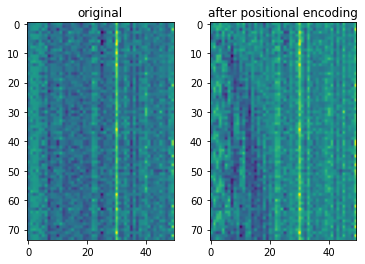

In [23]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(head_output.squeeze())
ax[1].imshow(x1)

ax[0].set_title("original")
ax[1].set_title("after positional encoding")

In [24]:
from self_attention import MultiHeadAttention

In [25]:
        

class NeuralNet(nn.Module):
    def __init__(self,batch_size = 1):
        
        super(NeuralNet,self).__init__()
        
        self.attention_head = MultiHeadAttention(in_features=50, head_num=1)
        self.batch_size = batch_size
        self.Q_head = torch.rand(self.batch_size,200,50) 
        self.K_head = torch.rand(self.batch_size,200,50)
        self.V_head = torch.rand(self.batch_size,200,50)
        
        self.attention_body = MultiHeadAttention(in_features=50, head_num=1)
        
        self.Q_body = torch.rand(self.batch_size,1000,50)
        self.K_body = torch.rand(self.batch_size,1000,50)
        self.V_body = torch.rand(self.batch_size,1000,50)
        
        # fully connected net 
                                
        self.fc1 = nn.Linear(60000, 500)   
    
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 30)
        self.fc4 = nn.Linear(30, 4)   
        
        self.softmax = nn.Softmax(dim=0)
        
        
    def forward(self,head,body):
                
        head = torch.tensor(head).float()
        body = torch.tensor(body).float()
                
        key_head = self.Q_head * head
        query_head = self.K_head * head
        value_head = self.V_head * head
        
        key_body = self.Q_body  * body
        query_body = self.K_body  * body
        value_body = self.V_body * body
    
        head_attention  = self.attention_head(key_head,query_head,value_head) 
        body_attention  = self.attention_body(key_body,query_body,value_body)
        
        
        merge = torch.cat((head_attention,body_attention),axis=1).reshape(self.batch_size,60000)
                
        
        output = self.fc1(merge)
        output = self.fc2(output)
                
        output = self.fc3(output)
        output = self.fc4(output)

        output = self.softmax(output)
        
        return output
        
        

In [26]:
net = NeuralNet(4)


In [27]:

creatrion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())


In [28]:

class dataset(torch.utils.data.Dataset):
    def __init__(self):
        
        self.head = head
        self.body = body
        self.target = target
    
    def __len__(self):
        return len(self.head)

    def pipeline(self,idx):

        represent_head = torch.tensor(representation(self.head[idx]))
        represent_body = torch.tensor(representation(self.body[idx]))


        padding_head = padding(represent_head,"head")
        padding_body = padding(represent_body,"body")


        positional_enc_head = np.array([pos_enc(val,i) for i,val in enumerate(padding_head)])
        positional_enc_body = np.array([pos_enc(val,i) for i,val in enumerate(padding_body)])


        return positional_enc_head,positional_enc_body,target[idx]
    
    def __getitem__(self,idx):
        return tuple(self.pipeline(idx))

    
dataset = dataset()
load = torch.utils.data.DataLoader(dataset,batch_size=4)


In [ ]:
# training

loss_ = []
data = iter(load)

for i,(h,b,t) in enumerate(data):
    
    optimizer.zero_grad()   
    
    output = net(h,b)
 
    loss = creatrion(output,t) 
    
    loss.backward()
    optimizer.step()  

    loss_.append(loss.item())
    print(loss)

    if i==50:
        break

<ipython-input-25-138b51ab8424>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  head = torch.tensor(head).float()
<ipython-input-25-138b51ab8424>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  body = torch.tensor(body).float()


tensor(1.3863, grad_fn=<NllLossBackward>)
tensor(1.3848, grad_fn=<NllLossBackward>)
tensor(1.4047, grad_fn=<NllLossBackward>)


In [ ]:
plt.plot(loss_)

In [34]:
# tesorboard
writer = SummaryWriter('stance/sn2')

data = iter(load)
h_,b_,t_ = next(data)

print(h_.shape)
print(b_.shape)


h_ = torch.Tensor(h_.float())
b_ = torch.Tensor(b_.float())
writer.add_graph(net,(h,b))
writer.close()

torch.Size([4, 200, 50])
torch.Size([4, 1000, 50])


<ipython-input-28-138b51ab8424>:31: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  head = torch.tensor(head).float()
<ipython-input-28-138b51ab8424>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  head = torch.tensor(head).float()
<ipython-input-28-138b51ab8424>:32: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  body = torch.ten